In [1]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)

from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [2]:
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

In [3]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats

np.random.seed(27);
torch.manual_seed(27);

In [4]:
swyft.zen()

  Cursed by the dimensionality of your nuisance space?
  Wasted by Markov chains that reject your simulations?
     Exhausted from messing with simplistic models,
because your inference algorithm cannot handle the truth?
         Try swyft for some pain relief.


In [15]:
DEVICE = 'cuda'

In [17]:
def model(v):
    a = v[0]
    b = v[1]
    r = (a**2+b**2)**0.5
    x=np.array([r])
    return dict(mu=x)

def noise(obs, v, noise = 0.01):
    x = obs['mu']
    n = np.random.randn(*x.shape)*noise
    return dict(x=x + n)

In [18]:
v0 = np.array([0.3, 0.1])
obs0 = model(v0)
obs0

{'mu': array([0.31622777])}

In [19]:
simulator = swyft.Simulator(model, sim_shapes = {"mu": (1,)})
prior = swyft.Prior.from_uv(lambda u: u*2-1, 2)

In [20]:
store = swyft.MemoryStore(['z0', 'z1'], simulator = simulator)

Creating new store.


In [ ]:
marginals = [[1, 0]]
bound = None
for N in [1000, 1000, 2000]:
    task = swyft.Task(N, prior, store, simhook = noise, bound = bound)
    task.simulate()
    task.add(marginals)
    task.train(marginals, train_args = dict(max_epochs = 30, lr_schedule = [1e-2, 1e-3]))
    bound = task.truncate(marginals, obs0)

Store: Adding 985 new samples to simulator store.
Simulator: Running...


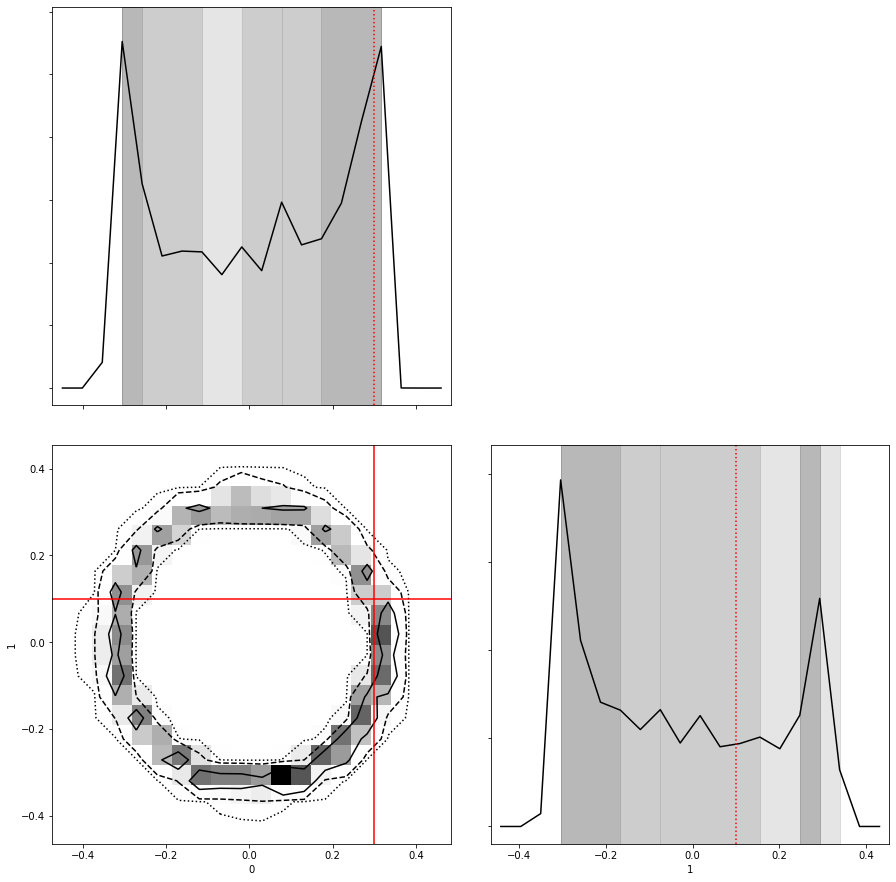

In [13]:
samples = task.posteriors.sample(10000, obs0)
swyft.corner(samples, [0, 1], color='k', figsize = (15,15), truth=v0, bins = 20)

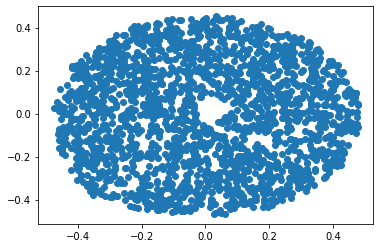

In [14]:
z = task.dataset.pars
plt.scatter(z[:,0], z[:,1])